In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [2]:
# from google.colab import output

In [3]:
# PB_path = '/content/drive/MyDrive/Colab Notebooks/Medical_Image_CV/data.zip'
# PB_path

In [4]:
# from zipfile import ZipFile
# file_name = PB_path
# with ZipFile(file_name, 'r') as zip:
#     # printing all the contents of the zip file
#     zip.printdir()
  
#     # extracting all the files
#     print('Extracting all the files now...')
#     zip.extractall('/content/drive/MyDrive/Colab Notebooks/Medical_Image_CV/')
#     print('Done!')

https://paperswithcode.com/task/medical-x-ray-image-segmentation

https://github.com/NoviceMAn-prog/MSRF-Net/blob/main/README.md

In [5]:
import os
import re

import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm
from PIL import Image

In [6]:
FRAME_PATH = '/content/drive/MyDrive/Colab Notebooks/Medical_Image_CV/data/training/Images'
MASK_PATH = '/content/drive/MyDrive/Colab Notebooks/Medical_Image_CV/data/training/Labels/Liver/'
# dtrain_t = '/content/drive/MyDrive/Colab Notebooks/Medical_Image_CV/data/training/Labels/Tumour/'
# dval = '/content/drive/MyDrive/Colab Notebooks/Medical_Image_CV/data/validation/images'
# dval_l = '/content/drive/MyDrive/Colab Notebooks/Medical_Image_CV/data/validation/labels/Liver/'
# dval_t = '/content/drive/MyDrive/Colab Notebooks/Medical_Image_CV/data/validation/labels/Tumour/'

In [7]:
images = sorted(os.listdir(FRAME_PATH))
mask = sorted(os.listdir(MASK_PATH))
mask = [fName for fName in mask]
image_file_name = [fName for fName in mask]

In [8]:
images[0]

'pat6_image_41.png'

In [9]:
mask[0]

'pat6_image_41.png'

In [10]:
image_file_name[0]

'pat6_image_41.png'

https://www.kaggle.com/pezhmansamadi/resu-net-retrain

https://github.com/rani700/xray/blob/master/train.ipynb

https://github.com/rani700/xray

In [11]:
check = [i for i in mask if ".png" in i]

In [12]:
len(check)

50

In [13]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
testing_files = set(os.listdir(FRAME_PATH)) & set(os.listdir(MASK_PATH))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(FRAME_PATH,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(MASK_PATH,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(FRAME_PATH,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(MASK_PATH,i)),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [15]:
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [16]:
dim = 256*2
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 50/50 [00:00<00:00, 69.65it/s]


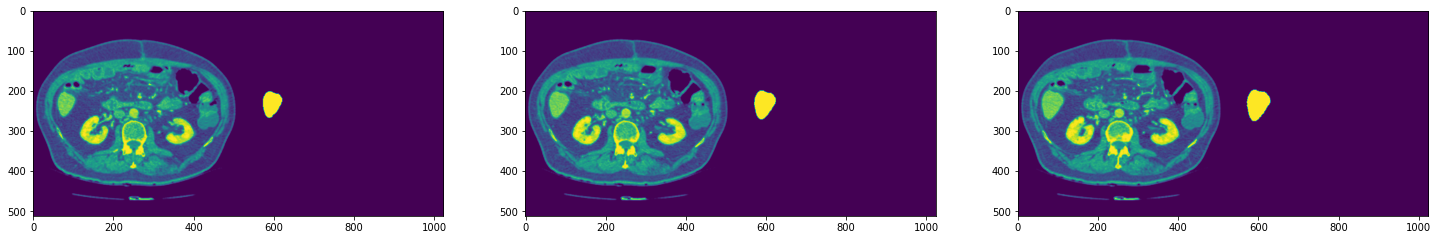

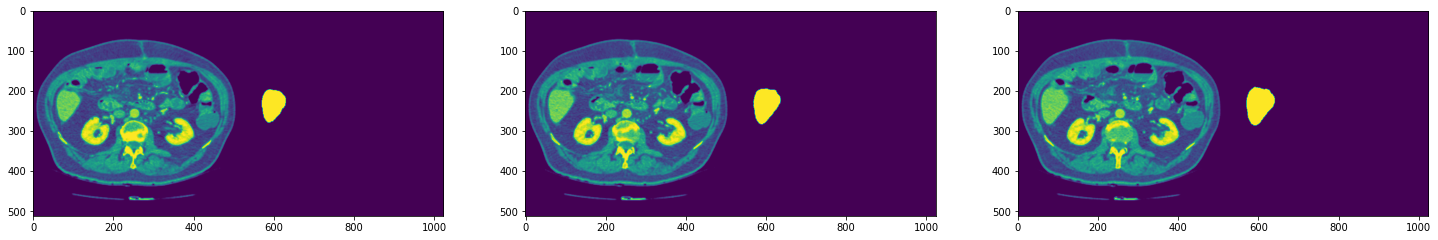

In [17]:
plotMask(X_train,y_train)

In [18]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [19]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [20]:
import tensorflow as tf

In [21]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [23]:
Adam = tf.keras.optimizers.Adam

In [24]:
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

model.compile(optimizer=Adam(learning_rate=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 8,
                  epochs = 5,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)


clear_output()

In [40]:
model.save('/content/drive/MyDrive/Colab Notebooks/Medical_Image_CV/model/model_MedSeg.h5')

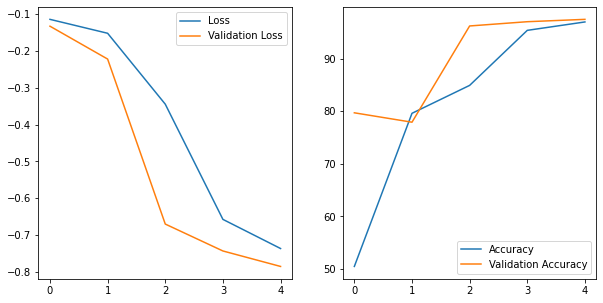

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

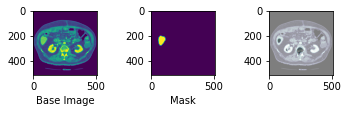

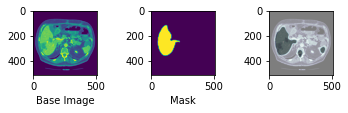

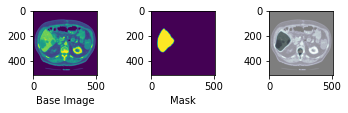

In [42]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

# plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]), cmap="bone")
    plt.imshow(np.squeeze(preds[pred_candidates[i]]), alpha=0.5, cmap="bone_r")
    plt.show()

In [43]:
pred_candidates

array([9, 8, 3, 3, 8, 6, 7, 8, 2, 4])

In [44]:
validation_vol[0].shape

(512, 512, 1)

In [45]:
img_path = "/content/drive/MyDrive/Colab Notebooks/Medical_Image_CV/data/validation/images/pat10_image_100.png"

In [46]:
X_shape = 256*2

In [47]:
x_im = cv2.resize(cv2.imread(img_path),(X_shape,X_shape))[:,:,0]

In [48]:
x_im.reshape(1, x_im.shape[0], x_im.shape[1], 1).shape

(1, 512, 512, 1)

In [49]:
x_im.shape

(512, 512)

In [50]:
op = model.predict((x_im.reshape(1, 512, 512, 1)-127.0)/127.0)

In [51]:
op.shape

(1, 512, 512, 1)

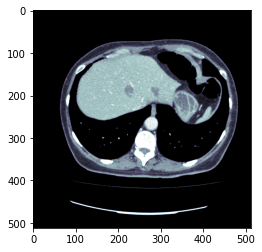

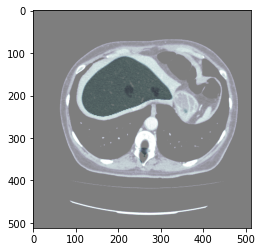

In [52]:
plt.imshow(x_im, cmap="bone", label="Input Image")
plt.show()

plt.imshow(x_im, cmap="bone", label="Output Image")
plt.imshow(op.reshape(512, 512), alpha=0.5, cmap="bone_r")
plt.show()

In [53]:
!ls

drive  sample_data
